In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import tensorflow as tf

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [20]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'inputs_z')
    
    return inputs_real, inputs_z

## generatorの定義

In [21]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):#reuse option:　関数内の変数の保持
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) #Leaky ReLU
        
        logits = tf.layers.dense(h1, out_dim, activation = None)
        out = tf.tanh(logits)
        
        return out

## discriminatorの定義

In [22]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [23]:
input_size = 28*28
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

In [27]:
tf.reset_default_graph()

input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, n_units=d_hidden_size, alpha=alpha)#関数内の変数を保持したものを使う

## 損失関数の定義

In [29]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)*(1-smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                     labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                               labels=tf.ones_like(d_logits_fake)))

## 最適化関数の定義

In [31]:
learning_rate = 0.002

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [37]:
batch_size = 128
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)

## トレーニング

In [47]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
                
            batch_images = batch[0].reshape((batch_size, 28*28))
            batch_images = batch_images * 2 -1
                
            #Generator
            batch_z = np.random.uniform(-1,1, size=(batch_size, z_size))
                
            _ = sess.run(d_train_optimize, feed_dict={input_real:batch_images, input_z:batch_z})
            _ = sess.run(g_train_optimize, feed_dict={input_z: batch_z})
            
        train_loss_d = sess.run(d_loss, feed_dict={input_z:batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
        
        print("epoch {}/{}".format(epoch+1, epochs), "D_loss: {:.4f}".format(train_loss_d), "G_loss: {:.4f}".format(train_loss_g))
        
        losses.append((train_loss_d, train_loss_g))
        
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                               feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')
        

        
with open('training_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)


epoch 1/100 D_loss: 0.3563 G_loss: 3.8095
epoch 2/100 D_loss: 0.4397 G_loss: 2.8277
epoch 3/100 D_loss: 0.3896 G_loss: 3.8352
epoch 4/100 D_loss: 2.3343 G_loss: 3.4054
epoch 5/100 D_loss: 3.4802 G_loss: 3.1341
epoch 6/100 D_loss: 1.0770 G_loss: 1.5880
epoch 7/100 D_loss: 0.8714 G_loss: 3.3680
epoch 8/100 D_loss: 3.1177 G_loss: 1.2509
epoch 9/100 D_loss: 1.1674 G_loss: 1.3650
epoch 10/100 D_loss: 1.9364 G_loss: 0.7368
epoch 11/100 D_loss: 1.0687 G_loss: 1.0908
epoch 12/100 D_loss: 1.1842 G_loss: 0.9396
epoch 13/100 D_loss: 3.2178 G_loss: 0.4655
epoch 14/100 D_loss: 1.7777 G_loss: 1.6424
epoch 15/100 D_loss: 1.6019 G_loss: 0.8832
epoch 16/100 D_loss: 0.8584 G_loss: 1.4113
epoch 17/100 D_loss: 1.3148 G_loss: 0.9105
epoch 18/100 D_loss: 0.9675 G_loss: 1.9822
epoch 19/100 D_loss: 1.9230 G_loss: 0.8219
epoch 20/100 D_loss: 2.7843 G_loss: 0.5750
epoch 21/100 D_loss: 1.4072 G_loss: 1.9722
epoch 22/100 D_loss: 0.9548 G_loss: 1.4156
epoch 23/100 D_loss: 1.2907 G_loss: 1.3213
epoch 24/100 D_loss:

## lossの可視化

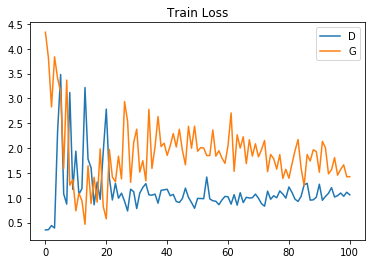

In [63]:
fig, ax = plt.subplots()
losses = np.array(losses)

plt.plot(losses.T[0], label='D')
plt.plot(losses.T[1], label='G')
plt.title('Train Loss')
plt.legend()

## 生成画像の可視化

In [55]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
    
    return fig.axes

In [56]:
with open('training_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

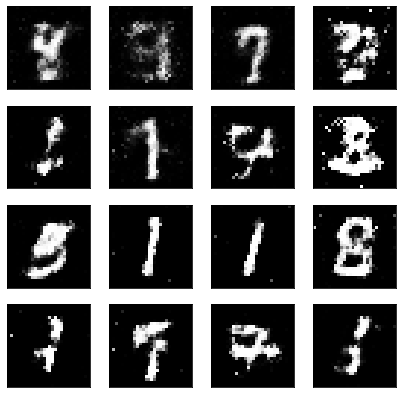

In [61]:
_ = view_samples(-1, samples)

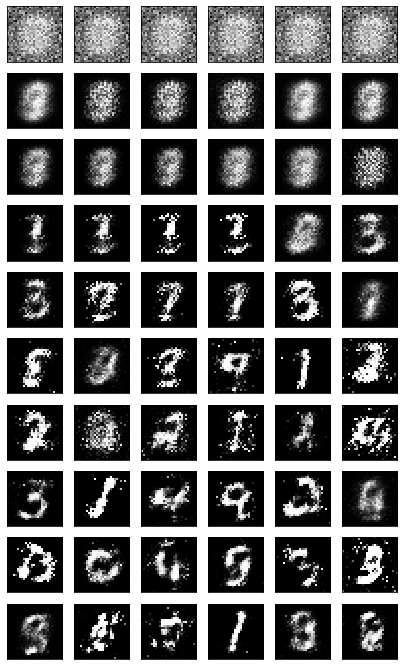

In [66]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape(28,28), cmap="Greys_r")
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## checkpointから画像生成

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


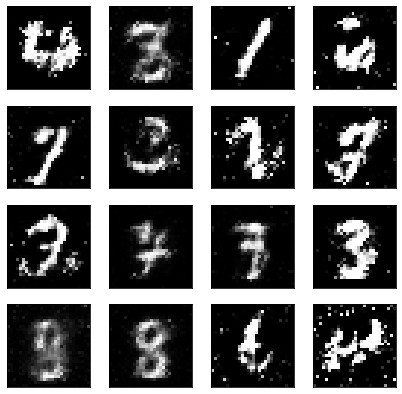

In [72]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1,1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
                          feed_dict={input_z: sample_z})

_ = view_samples(0, [gen_samples])